In [320]:
import pandas as pd

pd.set_option("display.max_columns", None)  # sets the max
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [341]:
df_mat = pd.read_csv("data/student-mat.csv", sep=";")
df_mat["course"] = "math"

df_por = pd.read_csv("data/student-por.csv", sep=";")
df_por["course"] = "portuguese"

df = pd.concat([df_mat, df_por], ignore_index=True)

features = df.columns
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math


# Feature engineering

## Average Grade

In [342]:
# AVG grade of each student
grad_mean = (df.G1 + df.G2 + df.G3) / 3
df["G_mean"] = grad_mean

numeric_features = df.select_dtypes("number")

<Axes: >

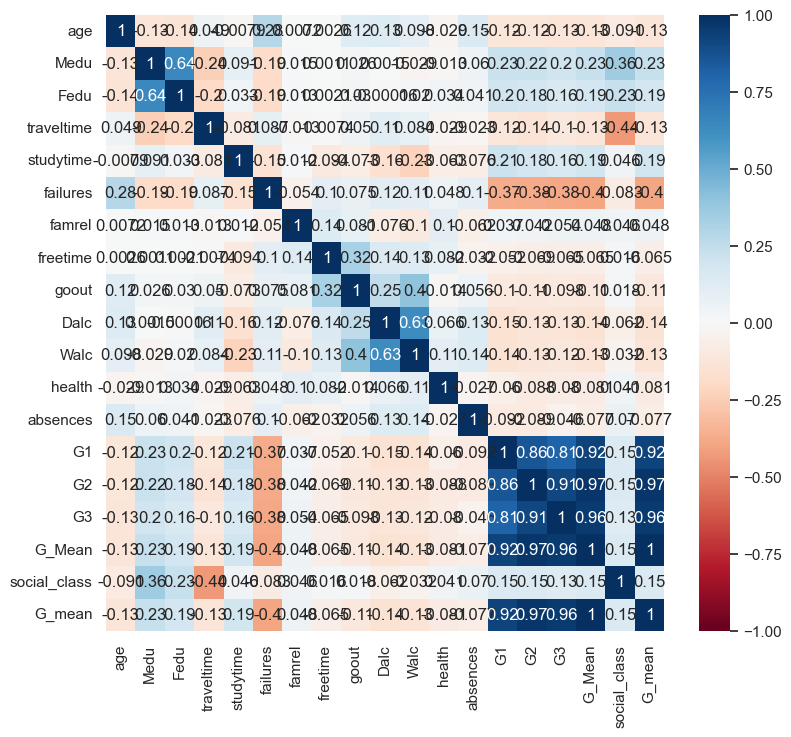

In [339]:
sns.set(rc={"figure.figsize": (9, 8)})
sns.heatmap(numeric_features.corr(), annot=True, cmap="RdBu", vmin=-1, vmax=1)

## Social Class (same socioeconomic status)

### Old approach

we are dividing social class into 3 groups; upper (U), middle (M) and lower (L) class.

- Parents educational level is the strongest proxy for social class
- Parents job is the second strongest proxy
- health???
- freetime after school
- internet
- extra-curricular activities
- family size

In [182]:
# Inferring social class based on parents education
print(
    f"{df[(df['Medu'] == 4) & (df['Fedu'] == 4)].shape[0]} rows where both mother and father has higher education"
)
print(
    f"{df[(df['Medu'] == 4) ^ (df['Fedu'] == 4)].shape[0]} rows where either mother or father has higher education (bot not both)"
)
print(
    f"{df[(df['Medu'] < 4) & (df['Fedu'] < 4)].shape[0]} rows where both the mother or father does not have a higher education"
)

165 rows where both mother and father has higher education
200 rows where either mother or father has higher education (bot not both)
679 rows where both the mother or father does not have a higher education


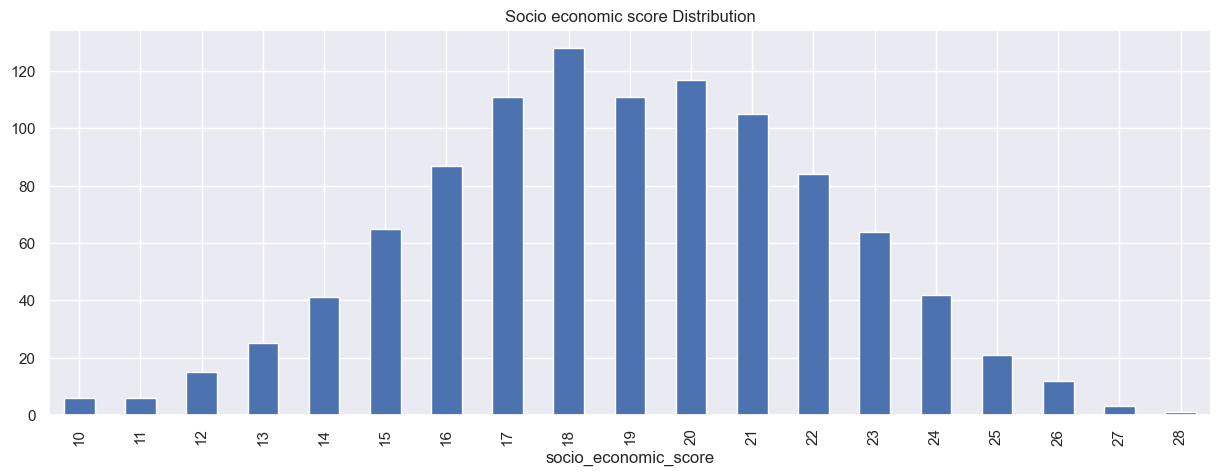

In [238]:
df_altered = df.copy()

df_altered["famsize"] = df_altered["famsize"].map(
    {"GT3": 1, "LE3": 2}
)  # 1 = Greater than 3, 2 = Less than 3
df_altered["Pstatus"] = df_altered["Pstatus"].map(
    {"A": 1, "T": 2}
)  # 1 = Apart, 2 = Together
df_altered["internet"] = df_altered["internet"].map({"no": 0, "yes": 1})

# this approach weights the features that are not on a ordinal scale
social_class_features = [
    "famsize",
    "Pstatus",
    "internet",
    "Medu",
    "Fedu",
    "health",
    "freetime",
    "goout", # include ???
]
df_altered["socio_economic_score"] = df_altered[social_class_features].sum(axis=1)

df_altered['socio_economic_score'].value_counts().sort_index().plot(kind="bar", figsize=(15, 5))
plt.title("Socio economic score Distribution")
plt.show()

### Agreed approach

In [343]:
df_social_status = df.copy()

df_social_status['internet'] = df_social_status['internet'].map({'no': 0, 'yes': 1})
df_social_status['traveltime'] = df_social_status['traveltime'].apply(lambda x: 0 if x >= 3 else 1)
df_social_status['address'] = df_social_status['address'].map({'U': 1, 'R': 0})
df_social_status['Mjob'] = df_social_status['Mjob'].apply(lambda x: 0 if x == "at_home" else 1)
df_social_status['Fjob'] = df_social_status['Fjob'].apply(lambda x: 0 if x == "at_home" else 1)
df_social_status['Medu'] = df_social_status['Medu'].apply(lambda x: 0 if x < 3 else 1)
df_social_status['Fedu'] = df_social_status['Fedu'].apply(lambda x: 0 if x < 3 else 1)

social_class_features = ['internet', 'traveltime', 'address', 'Mjob', 'Fjob', 'Medu', 'Fedu']

df_social_status['social_economic_score'] = df_social_status[social_class_features].sum(axis=1)
df_social_status['social_class'] = df_social_status['social_economic_score'].apply(lambda x: "higher_economic_class" if x >= 4 else "lower_economic_class")

# save dataset
df_social_status.to_csv("data/all_student_and_socio_economic.csv")

df_social_status

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course,G_mean,social_economic_score,social_class
0,GP,F,18,1,GT3,A,1,1,0,1,course,mother,1,2,0,yes,no,no,no,yes,yes,0,no,4,3,4,1,1,3,6,5,6,6,math,5.666667,5,higher_economic_class
1,GP,F,17,1,GT3,T,0,0,0,1,course,father,1,2,0,no,yes,no,no,no,yes,1,no,5,3,3,1,1,3,4,5,5,6,math,5.333333,4,higher_economic_class
2,GP,F,15,1,LE3,T,0,0,0,1,other,mother,1,2,3,yes,no,yes,no,yes,yes,1,no,4,3,2,2,3,3,10,7,8,10,math,8.333333,4,higher_economic_class
3,GP,F,15,1,GT3,T,1,0,1,1,home,mother,1,3,0,no,yes,yes,yes,yes,yes,1,yes,3,2,2,1,1,5,2,15,14,15,math,14.666667,6,higher_economic_class
4,GP,F,16,1,GT3,T,1,1,1,1,home,father,1,2,0,no,yes,yes,no,yes,yes,0,no,4,3,2,1,2,5,4,6,10,10,math,8.666667,6,higher_economic_class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,F,19,0,GT3,T,0,1,1,1,course,mother,1,3,1,no,no,no,yes,no,yes,1,no,5,4,2,1,2,5,4,10,11,10,portuguese,10.333333,5,higher_economic_class
1040,MS,F,18,1,LE3,T,1,0,1,1,course,mother,1,2,0,no,yes,no,no,yes,yes,1,no,4,3,4,1,1,1,4,15,15,16,portuguese,15.333333,6,higher_economic_class
1041,MS,F,18,1,GT3,T,0,0,1,1,course,mother,1,2,0,no,no,no,yes,yes,yes,0,no,1,1,1,1,1,5,6,11,12,9,portuguese,10.666667,4,higher_economic_class
1042,MS,M,17,1,LE3,T,1,0,1,1,course,mother,1,1,0,no,no,no,no,no,yes,1,no,2,4,5,3,4,2,6,10,10,10,portuguese,10.000000,6,higher_economic_class


<Axes: xlabel='social_class', ylabel='G_Mean'>

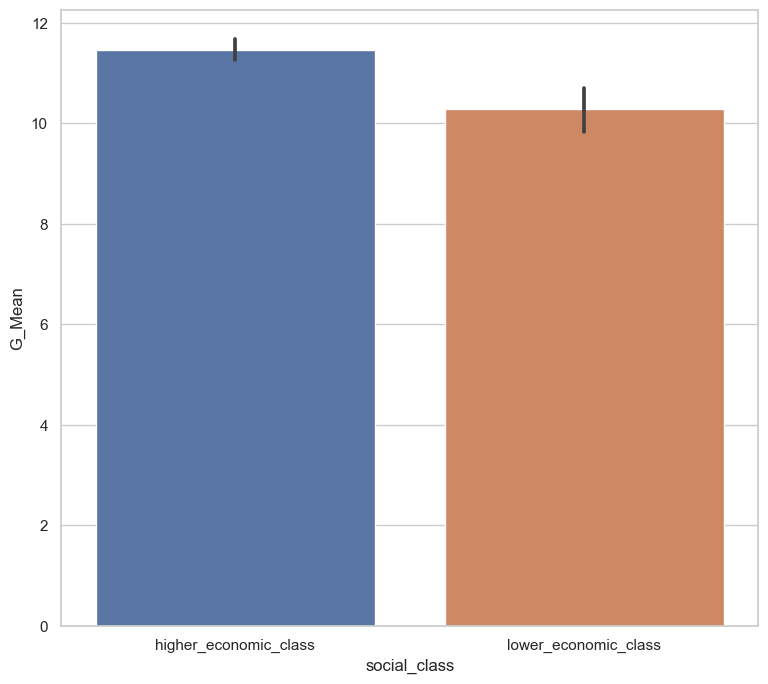

In [334]:
sns.barplot(x="social_class", y="G_Mean", data=df_social_status)

<Axes: xlabel='G_Mean', ylabel='Count'>

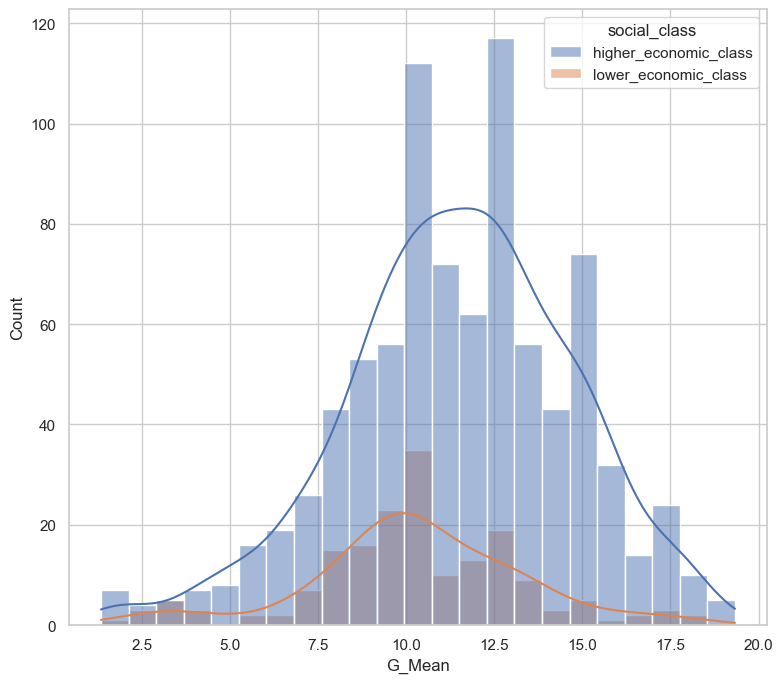

In [335]:
sns.histplot(x="G_Mean", hue="social_class", data=df_social_status, kde=True)

<Axes: >

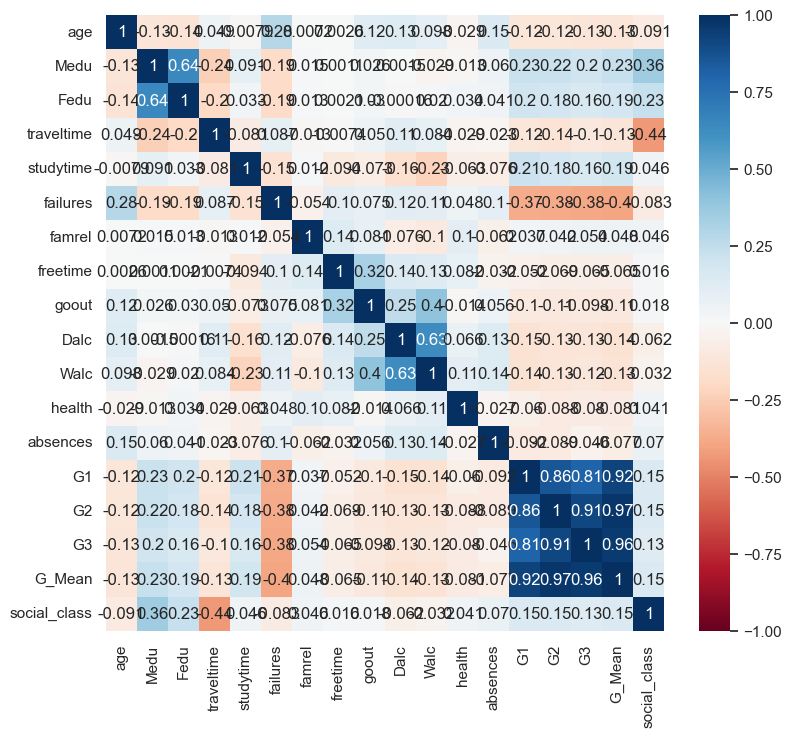

In [336]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True, cmap="RdBu", vmin=-1, vmax=1)

# EDA

## Sensitive Variables

### AGE

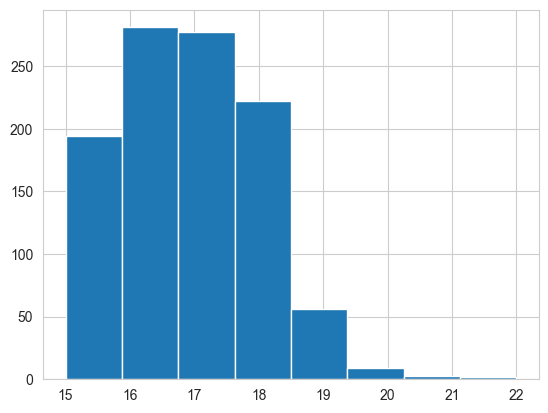

In [185]:
plt.hist(df["age"], bins=8)
plt.show()

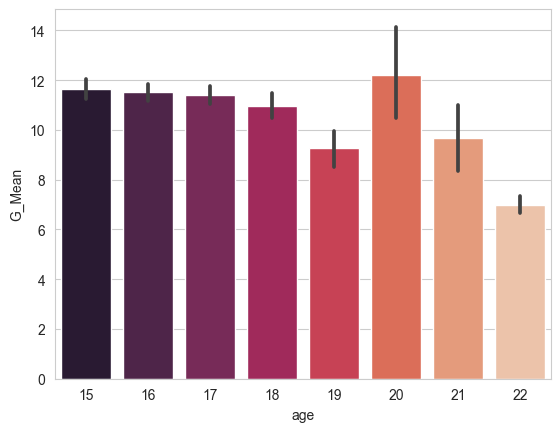

In [186]:
sns.barplot(data=df, x="age", y="G_Mean", palette="rocket", errorbar=("ci", 95))
plt.show()


<Axes: xlabel='age'>

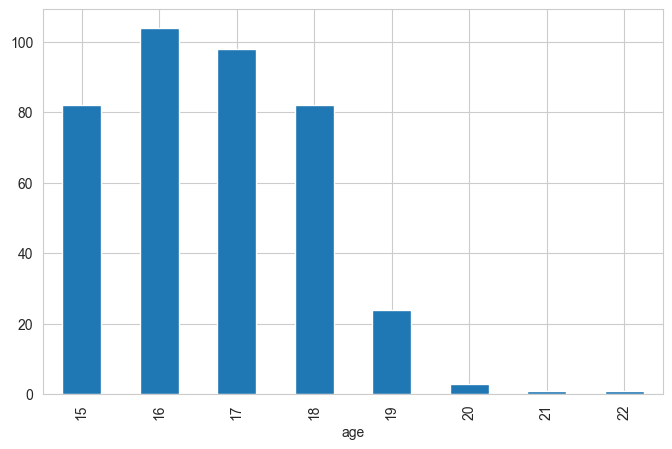

In [152]:
df.age.value_counts().sort_index().plot(kind="bar", figsize=(8, 5))

<Axes: xlabel='age', ylabel='studytime'>

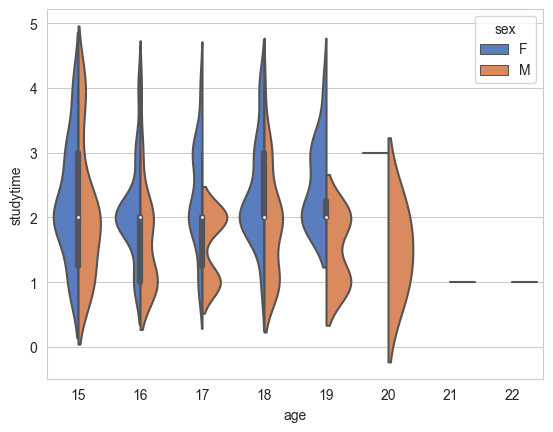

In [19]:
sns.violinplot(x="age", y="studytime", hue="sex", data=df, palette="muted", split=True)


In [188]:
sns.violinplot(x="studytime", hue="sex")

ValueError: Could not interpret input 'studytime'

<Axes: xlabel='age', ylabel='failures'>

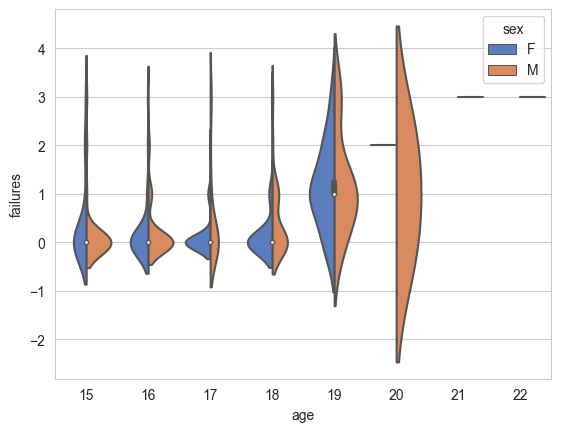

In [22]:
sns.violinplot(x="age", y="failures", hue="sex", data=df, palette="muted", split=True)


### SEX

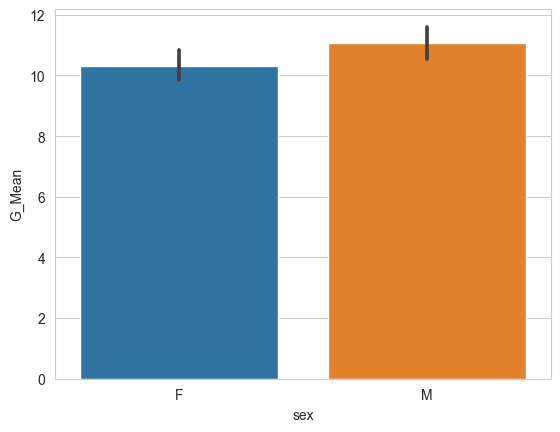

In [52]:
sns.barplot(x="sex", y="G_Mean", data=df)
plt.show()

In [100]:
display(df.groupby("sex").G1.mean())
display(df.groupby("sex").G2.mean())
display(df.groupby("sex").G3.mean())
display(df.groupby("sex").G_Mean.mean())


sex
F    10.620192
M    11.229947
Name: G1, dtype: float64

sex
F    10.389423
M    11.074866
Name: G2, dtype: float64

sex
F     9.966346
M    10.914439
Name: G3, dtype: float64

sex
F    10.325321
M    11.073084
Name: G_Mean, dtype: float64

Males are on average getting a higher grade than females

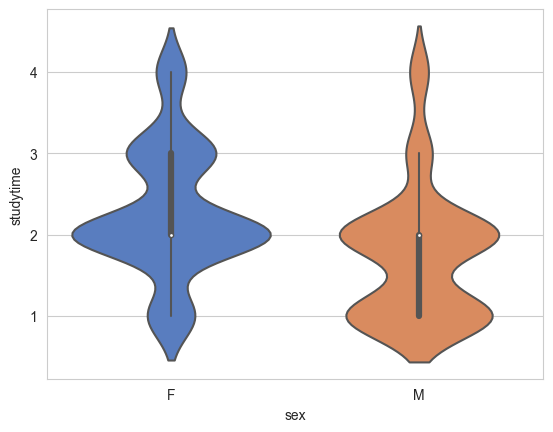

In [154]:
# sex vs studytime
sns.violinplot(x="sex", y="studytime", data=df, palette="muted", split=True)
plt.show()

Female tend to study more than males

## Non-sensitive variables

In [199]:
df_mat.shape[0]

395

In [200]:
df_mat[df_mat['G3'] < 13].shape[0]

264

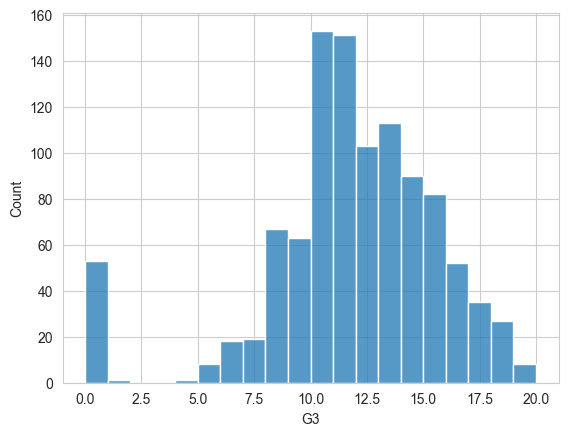

In [202]:
sns.histplot(x="G3",data=df, bins=20)
plt.show()

In [197]:
df_por.shape[0]

649

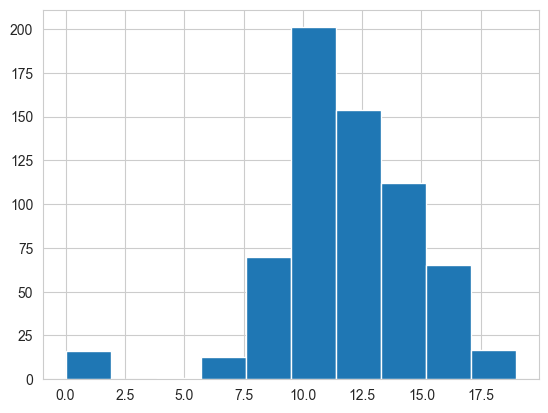

In [194]:
plt.hist(df_por['G3'])
plt.show()

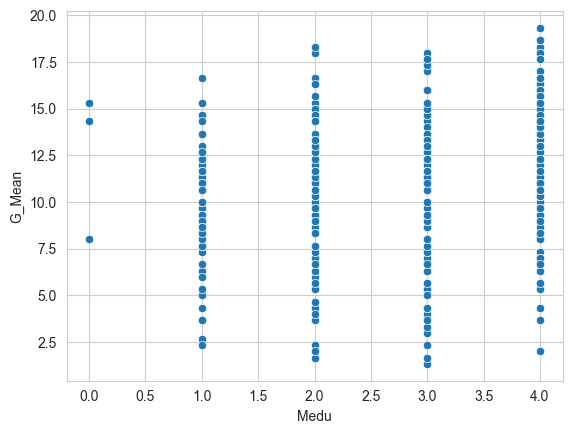

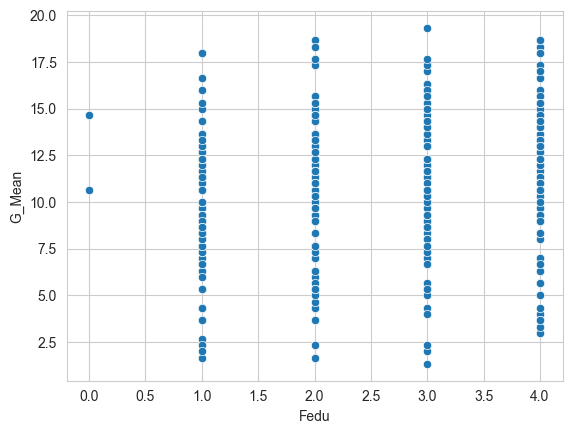

In [60]:
sns.scatterplot(x="Medu", y="G_Mean", data=df)
plt.show()
sns.scatterplot(x="Fedu", y="G_Mean", data=df)
plt.show()